# PLN 2021 Q3 Projeto

Este projeto aborda a aplicação de Modelagem de Tópicos, Similaridade de Textos e Sumarização de Textos em uma base de dados de artigos científicos de uma conferência de machine learning.

O objetivo do projeto é analisar a mudança de tópicos presentes nos papers da conferência ao longo dos anos, e construir um sistema recomendador de papers com base nos tópicos.

A base de dados escolhida foi a base de [Papers da NIPS](https://www.kaggle.com/benhamner/nips-papers)

# 1. Base de Dados

## 1.0 Baixando e extraindo arquivos

In [4]:
%%capture
!pip install py7zr multivolumefile

In [5]:
# Baixando arquivos
import requests
import os

github_files = [
    ('database/database.7z.001', 'database.7z.001'),
    ('database/database.7z.002', 'database.7z.002'),
    ('database/database.7z.003', 'database.7z.003'),
    ('results1.csv', 'results1.csv'),
    ('results2.csv', 'results2.csv'),
    ('results2.csv', 'results.csv'),
    ('models/model_n15_p20.gensim', 'model_n15_p20.gensim'),
    ('models/model_n15_p20.gensim.expElogbeta.npy', 'model_n15_p20.gensim.expElogbeta.npy'),
    ('models/model_n15_p20.gensim.id2word', 'model_n15_p20.gensim.id2word'),
    ('models/model_n15_p20.gensim.state', 'model_n15_p20.gensim.state')
]

def download(url_file_tuples):
    for url, f in url_file_tuples:
        print(f'checking {f}')
        if not os.path.isfile(f):
            if not url.startswith('https'):
                url = f'https://github.com/brusangues/pln-2021Q3-papers/blob/main/{url}?raw=true'
            print(f'downloading {url}')
            try:
                with open(f, 'wb') as f_open:
                    r = requests.get(url, allow_redirects=True)
                    f_open.write(r.content)
            except Exception as e:
                print(str(e))
        else:
            print(f'file already exists')

download(github_files)

checking database.7z.001
downloading https://github.com/brusangues/pln-2021Q3-papers/blob/main/database/database.7z.001?raw=true
checking database.7z.002
downloading https://github.com/brusangues/pln-2021Q3-papers/blob/main/database/database.7z.002?raw=true
checking database.7z.003
downloading https://github.com/brusangues/pln-2021Q3-papers/blob/main/database/database.7z.003?raw=true
checking results1.csv
downloading https://github.com/brusangues/pln-2021Q3-papers/blob/main/results1.csv?raw=true
checking results2.csv
downloading https://github.com/brusangues/pln-2021Q3-papers/blob/main/results2.csv?raw=true
checking results.csv
downloading https://github.com/brusangues/pln-2021Q3-papers/blob/main/results2.csv?raw=true
checking model_n15_p20.gensim
downloading https://github.com/brusangues/pln-2021Q3-papers/blob/main/models/model_n15_p20.gensim?raw=true
checking model_n15_p20.gensim.expElogbeta.npy
downloading https://github.com/brusangues/pln-2021Q3-papers/blob/main/models/model_n15_p2

In [6]:
# Abrindo 7z
import multivolumefile
import py7zr
if not os.path.isfile('database.sqlite'):
    with multivolumefile.open('database.7z', mode='rb') as target_archive:
        with py7zr.SevenZipFile(target_archive, 'r') as archive:
            archive.extractall()

## 1.1. Lendo base SQL

Inicialmente, pensou-se em trabalhar com os autores dos artigos. Mas essa ideia foi abandonada.

In [7]:
# Extraindo dataframe da base de dados em SQL
import pandas as pd
import sqlite3
import numpy as np

query1 = '''
SELECT * FROM papers
ORDER BY papers.id;
'''
query2 = '''
SELECT id, year, title, names_count, names_list, event_type, pdf_name, abstract, paper_text 
FROM 
    papers, 
    (
        SELECT papers.id AS paper_id, 
            count(authors.name) AS names_count,
            group_concat(authors.name, ', ') AS names,
            '["' || group_concat(authors.name, '","') || '"]' AS names_list
        FROM papers, authors, paper_authors
        WHERE
            authors.id == paper_authors.author_id AND 
            papers.id == paper_authors.paper_id
        GROUP BY papers.id
    ) AS authors_grouped
WHERE
    authors_grouped.paper_id == papers.id
ORDER BY papers.id;
'''

db_file = "/content/database.sqlite"
with sqlite3.connect(db_file) as con:
    papers = pd.read_sql_query(query2, con)
print(papers.shape)
#papers.sample(3)

(7238, 9)


In [8]:
# Tratando coluna de nomes de autores como lista
import ast
papers['names_list'] = papers.names_list.apply(ast.literal_eval)
papers.sample(3)

,id,year,title,names_count,names_list,event_type,pdf_name,abstract,paper_text
2492,2531,2003,Log-Linear Models for Label Ranking,3,"[Ofer Dekel, Yoram Singer, Christopher D. Mann...",,2531-log-linear-models-for-label-ranking.pdf,Abstract Missing,Log-Linear Models for Label Ranking\n\nOfer De...
3686,3725,2009,Bayesian Belief Polarization,3,"[Alan Jern, Kai-min Chang, Charles Kemp]",,3725-bayesian-belief-polarization.pdf,Situations in which people with opposing prior...,Bayesian Belief Polarization\n\nAlan Jern\nDep...
1070,1095,1995,Worst-case Loss Bounds for Single Neurons,3,"[David P. Helmbold, Jyrki Kivinen, Manfred K. ...",,1095-worst-case-loss-bounds-for-single-neurons...,Abstract Missing,Worst-case Loss Bounds\nfor Single Neurons\n\n...


In [9]:
papers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7238 entries, 0 to 7237
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           7238 non-null   int64 
 1   year         7238 non-null   int64 
 2   title        7238 non-null   object
 3   names_count  7238 non-null   int64 
 4   names_list   7238 non-null   object
 5   event_type   7238 non-null   object
 6   pdf_name     7238 non-null   object
 7   abstract     7238 non-null   object
 8   paper_text   7238 non-null   object
dtypes: int64(3), object(6)
memory usage: 509.0+ KB


In [10]:
# Salvando corpus como um vetor
corpus = papers['paper_text'].values
print(corpus.shape)
corpus[:3]

(7238,)


array(['767\n\nSELF-ORGANIZATION OF ASSOCIATIVE DATABASE\nAND ITS APPLICATIONS\nHisashi Suzuki and Suguru Arimoto\nOsaka University, Toyonaka, Osaka 560, Japan\nABSTRACT\nAn efficient method of self-organizing associative databases is proposed together with\napplications to robot eyesight systems. The proposed databases can associate any input\nwith some output. In the first half part of discussion, an algorithm of self-organization is\nproposed. From an aspect of hardware, it produces a new style of neural network. In the\nlatter half part, an applicability to handwritten letter recognition and that to an autonomous\nmobile robot system are demonstrated.\n\nINTRODUCTION\nLet a mapping f : X -+ Y be given. Here, X is a finite or infinite set, and Y is another\nfinite or infinite set. A learning machine observes any set of pairs (x, y) sampled randomly\nfrom X x Y. (X x Y means the Cartesian product of X and Y.) And, it computes some\nestimate j : X -+ Y of f to make small, the estimati

## 1.2. Tokenizador

In [11]:
import nltk
nltk.download("punkt")
nltk.download("stopwords")
nltk.download("wordnet")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [12]:
# Criando tokenizador customizado
from nltk.tokenize import wordpunct_tokenize
from nltk.corpus import stopwords
stopwords = stopwords.words('english')

from nltk.stem.porter import PorterStemmer
stm = PorterStemmer()

from nltk.stem.wordnet import WordNetLemmatizer
wnl = WordNetLemmatizer()

import string

def custom_tokenizer(text, reduc, min_len=4):
    text = str(text)
    words = wordpunct_tokenize(text) 
    # Removendo pontuação e tornando lowercase
    words = [word.lower() for word in words if word.isalpha()]
    # Removendo stopwords
    words = [word for word in words if word not in stopwords]
    
    if reduc.lower() == 'lemmatizer':
        words = [wnl.lemmatize(word) for word in words] 
    else:
        words = [stm.stem(word) for word in words]
    
    words = [word for word in words if min_len <= len(word)]
    return words

# Funções separadas serão úteis posteriormente
def tokenizer_lemma(text, min_len=4):
    return custom_tokenizer(text, reduc='lemmatizer', min_len=min_len)
def tokenizer_stem(text, min_len=4):
    return custom_tokenizer(text, reduc='stemmer', min_len=min_len)

In [13]:
tokenizer_lemma("Sample poem. Ends here.")

['sample', 'poem']

## 1.3. Tokenizando o Corpus

In [14]:
# Definindo função para realizar mapeamento mostrando barra de progresso
from tqdm import tqdm
def map_progress(func, iterable):
    tqdm_iter = tqdm(iterable)
    return list(map(func, tqdm_iter))

In [15]:
corpus_processed = map_progress(tokenizer_lemma, corpus)

100%|██████████| 7238/7238 [03:12<00:00, 37.65it/s]


# 2. Modelagem de Tópicos utilizando LDA


Nesta seção, o LDA será aplicado primeramente no corpus completo, e depois no corpus referente a intervalos de 5 anos.

## 2.1. Modelagem para todos os anos

### 2.1.1. Gerando Dicionário e Bag of Words


In [16]:
%%capture
!pip install pyLDAvis==2.1.2

In [17]:
from gensim import corpora

gensim_dictionary = corpora.Dictionary(corpus_processed)
#gensim_corpus = [gensim_dictionary.doc2bow(token, allow_update=True) for token in corpus_processed]
gensim_corpus = map_progress(lambda x:gensim_dictionary.doc2bow(x, allow_update=True), corpus_processed)

100%|██████████| 7238/7238 [00:12<00:00, 565.37it/s]


In [18]:
import pickle

pickle.dump(gensim_corpus, open('gensim_corpus_corpus.pkl', 'wb'))
gensim_dictionary.save('gensim_dictionary.gensim')

### 2.1.2. Treinando um modelo LDA qualquer

Primeiramente, um modelo simples foi gerado com parâmetros arbitrários

In [ ]:
# Treinando modelo
import gensim

lda_model = gensim.models.ldamodel.LdaModel(gensim_corpus, num_topics=4, id2word=gensim_dictionary, passes=20)
lda_model.save('gensim_model.gensim')

In [ ]:
# Imprimindo tópicos encontrados
topics = lda_model.print_topics(num_words=10)
for topic in topics:
    print(topic)

(0, '0.016*"model" + 0.013*"image" + 0.011*"network" + 0.010*"learning" + 0.009*"feature" + 0.009*"training" + 0.007*"layer" + 0.006*"using" + 0.006*"data" + 0.006*"object"')
(1, '0.010*"data" + 0.010*"algorithm" + 0.009*"model" + 0.009*"matrix" + 0.008*"method" + 0.007*"function" + 0.007*"problem" + 0.006*"distribution" + 0.005*"kernel" + 0.005*"point"')
(2, '0.016*"algorithm" + 0.012*"learning" + 0.011*"function" + 0.008*"problem" + 0.008*"bound" + 0.006*"state" + 0.006*"policy" + 0.006*"time" + 0.006*"value" + 0.005*"loss"')
(3, '0.014*"model" + 0.012*"network" + 0.010*"time" + 0.008*"neuron" + 0.007*"neural" + 0.007*"input" + 0.006*"figure" + 0.006*"system" + 0.005*"state" + 0.004*"unit"')


In [ ]:
# Encontrando tópico de um documento novo
test_doc = 'Great structures are build to remember an event happened in the history.'
test_doc = tokenizer_lemma(test_doc)
bow_test_doc = gensim_dictionary.doc2bow(test_doc)

print(lda_model.get_document_topics(bow_test_doc))

[(0, 0.03377141), (1, 0.032427832), (2, 0.033378836), (3, 0.900422)]


In [ ]:
# Calculando métricas
print('\nPerplexity:', lda_model.log_perplexity(gensim_corpus))

from gensim.models import CoherenceModel

coherence_score_lda = CoherenceModel(model=lda_model, texts=corpus_processed, dictionary=gensim_dictionary, coherence='c_v')
coherence_score = coherence_score_lda.get_coherence()

print('\nCoherence Score:', coherence_score)


Perplexity: -7.860800889041973

Coherence Score: 0.3899742016159349


In [ ]:
# Visualizando tópicos
gensim_dictionary = gensim.corpora.Dictionary.load('gensim_dictionary.gensim')
gensim_corpus = pickle.load(open('gensim_corpus_corpus.pkl', 'rb'))
lda_model = gensim.models.ldamodel.LdaModel.load('gensim_model.gensim')

import pyLDAvis.gensim

lda_visualization = pyLDAvis.gensim.prepare(lda_model, gensim_corpus, gensim_dictionary, sort_topics=False)
pyLDAvis.display(lda_visualization)

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


### 2.1.3. Encontrando melhor valor de N

Nesta seção, diferentes valores de N são testados para encontrar o número de tópicos ideal (se é que existe), e orientar as próximas etapas do projeto.

In [ ]:
import gensim
from gensim.models import CoherenceModel
import pyLDAvis.gensim
import sys
from collections import defaultdict
import gc
import time
import warnings
warnings.filterwarnings("ignore")

# Dicionário de resultados
results = defaultdict(dict)

In [ ]:
# Números de tópicos testados
ns = [5,10,15,20,30,40,50]
passes = 20

In [ ]:
# Iterando sobre os números de tópicos
for i, n in enumerate(ns):
    # Initialization
    start = time.time()
    n_str = f"n={n}"
    print(f"n: {n}",end=" | ")

    # Train
    print("train",end=" | ")
    lda_model = gensim.models.ldamodel.LdaModel(gensim_corpus, num_topics=n, id2word=gensim_dictionary, passes=passes)

    # Eval
    print("eval",end=" | ")
    # Perplexity    
    perplexity = lda_model.log_perplexity(gensim_corpus)
    print("perplexity: {:0.2f}".format(perplexity),end=" | ")

    # Coherence
    coherence_score_lda = CoherenceModel(model=lda_model, texts=corpus_processed, dictionary=gensim_dictionary, coherence='c_v')
    coherence_score = coherence_score_lda.get_coherence()
    print("coherence: {:0.2f}".format(coherence_score),end=" | ")

    # Runtime
    runtime = time.time() - start
    results[n_str]['runtime'] = runtime
    print("runtime: {:0.2f} s".format(runtime),end=" | ")

    # Results
    results[n_str]['n'] = n
    results[n_str]['model'] = lda_model
    results[n_str]['perplexity'] = perplexity
    results[n_str]['coherence'] = coherence_score
    results[n_str]['passes'] = passes
    model_file = f'model_n{n}_p{passes}.gensim'
    lda_model.save(model_file)

    # Remaining time
    end_time = runtime*(len(ns)-(i+1))
    print("ECT: {:0.2f} m \n".format(end_time/60),end="")

n: 5 | train | eval | perplexity: -7.85 | coherence: 0.37 | runtime: 755.73 s | ECT: 75.57 m 
n: 10 | train | eval | perplexity: -7.77 | coherence: 0.44 | runtime: 1126.12 s | ECT: 93.84 m 
n: 15 | train | eval | perplexity: -7.72 | coherence: 0.46 | runtime: 1364.48 s | ECT: 90.97 m 
n: 20 | train | eval | perplexity: -7.70 | coherence: 0.46 | runtime: 1488.15 s | ECT: 74.41 m 
n: 30 | train | eval | perplexity: -7.67 | coherence: 0.46 | runtime: 1822.69 s | ECT: 60.76 m 
n: 40 | train | eval | perplexity: -7.65 | coherence: 0.45 | runtime: 2590.68 s | ECT: 43.18 m 
n: 50 | train | eval | perplexity: -7.63 | coherence: 0.46 | runtime: 2496.46 s | ECT: 0.00 m 


### 2.1.4. Resultados dos testes para encontrar melhor valor de N

In [19]:
# Lendo dicionários como dataframe
resultsDF = pd.read_csv("results2.csv", index_col=0, sep=';')
#resultsDF = pd.DataFrame.from_dict(results, orient='index')

# Salvando resultados em csv
resultsDF.to_csv('results.csv', sep=';')
resultsDF.to_pickle('results.pickle')

resultsDF

,runtime,n,model,perplexity,coherence,passes
n=5,755.734038,5,"LdaModel(num_terms=151108, num_topics=5, decay...",-7.848138,0.372097,20
n=10,1126.121850,10,"LdaModel(num_terms=151108, num_topics=10, deca...",-7.767882,0.443217,20
n=15,1364.476118,15,"LdaModel(num_terms=151108, num_topics=15, deca...",-7.723618,0.463385,20
n=20,1488.149697,20,"LdaModel(num_terms=151108, num_topics=20, deca...",-7.695812,0.455973,20
n=30,1822.686493,30,"LdaModel(num_terms=151108, num_topics=30, deca...",-7.669511,0.463684,20
n=40,2590.683170,40,"LdaModel(num_terms=151108, num_topics=40, deca...",-7.647554,0.449894,20
n=50,2496.455261,50,"LdaModel(num_terms=151108, num_topics=50, deca...",-7.634034,0.458960,20


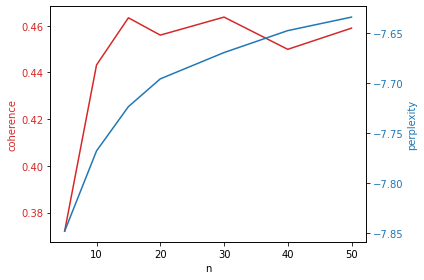

In [132]:
# Visualizando coerência e perplexidade em função de n
# https://matplotlib.org/devdocs/gallery/subplots_axes_and_figures/two_scales.html

import numpy as np
import matplotlib.pyplot as plt

def plot_results(resultsDF):
    fig, ax1 = plt.subplots()

    color = 'tab:red'
    ax1.set_xlabel('n')
    ax1.set_ylabel('coherence', color=color)
    ax1.plot(resultsDF.n, resultsDF.coherence, color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:blue'
    ax2.set_ylabel('perplexity', color=color)  # we already handled the x-label with ax1
    ax2.plot(resultsDF.n, resultsDF.perplexity, color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()

plot_results(resultsDF)

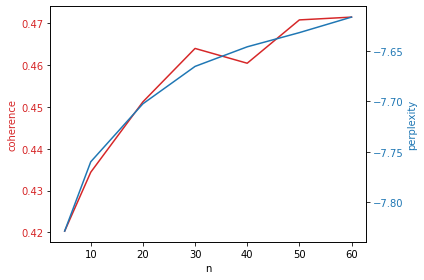

In [133]:
# Visualizando outra rodada para os mesmos parâmetros
plot_results(pd.read_csv("results1.csv", index_col=0, sep=';'))

Ao analisar os dois gráficos, nota-se que a coerência varia bastante conforme a semente aleatória do modelo. Mesmo assim, ambas as métricas aumentam conforme N cresce.

Sabendo que um bom modelo tem alta coerência e baixa perplexidade, o valor de N escolhido foi 15, pois mostrou coerência similar aos valores de N superiores, mantendo a perplexidade baixa. 

Além disso, um número menor de tópicos é mais facilmente visualizado.

### 2.1.5. Testes com melhor modelo

In [20]:
# Definindo número de tópicos
n = 15
passes = 20

In [21]:
import gensim
from gensim.models import CoherenceModel
import pyLDAvis.gensim
import sys
from collections import defaultdict
import gc
import time
import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


In [22]:
# Carregando ou gerando modelo
model_file = f'model_n{n}_p{passes}.gensim'
try:
    lda_model = gensim.models.ldamodel.LdaModel.load(model_file)
    coherence_score = resultsDF['coherence'][f'n={n}']
    perplexity = resultsDF['perplexity'][f'n={n}']
except:
    # Initialization
    start = time.time()
    print(f"n: {n}",end=" | ")
    if not os.path.isfile(model_file):
        # Train
        print("train",end=" | ")
        lda_model = gensim.models.ldamodel.LdaModel(gensim_corpus, num_topics=n, id2word=gensim_dictionary, passes=passes)
        # save model
        lda_model.save(model_file)
    else:
        lda_model = gensim.models.ldamodel.LdaModel.load(model_file)
    # Perplexity    
    perplexity = lda_model.log_perplexity(gensim_corpus)
    print("perplexity: {:0.2f}".format(perplexity),end=" | ")
    # Coherence
    coherence_score_lda = CoherenceModel(model=lda_model, texts=corpus_processed, dictionary=gensim_dictionary, coherence='c_v')
    coherence_score = coherence_score_lda.get_coherence()
    print("coherence: {:0.2f}".format(coherence_score),end=" | ")
    # Runtime
    runtime = time.time() - start
    print("runtime: {:0.2f} s".format(runtime),end=" | ")

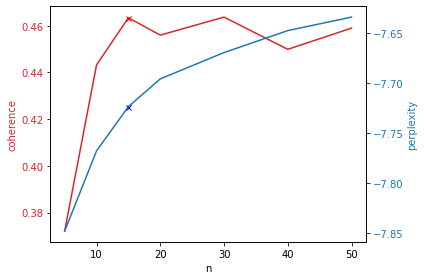

In [135]:
# Resultado do melhor modelo em relação aos testes para definir melhor n
import matplotlib.pyplot as plt
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('n')
ax1.set_ylabel('coherence', color=color)
ax1.plot(resultsDF.n, resultsDF.coherence, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('perplexity', color=color)  # we already handled the x-label with ax1
ax2.plot(resultsDF.n, resultsDF.perplexity, color=color)
ax2.tick_params(axis='y', labelcolor=color)

# Coerência e perplexidade do modelo gerado
ax1.plot([n], [coherence_score],  marker="x", markersize=5, markeredgecolor="red",  markerfacecolor="black")
ax2.plot([n], [perplexity], marker="x", markersize=5, markeredgecolor="blue", markerfacecolor="black")

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [137]:
# Imprimindo tópicos
topics = lda_model.print_topics(num_words=5)
for topic in topics:
    print(topic)

(0, '0.031*"matrix" + 0.017*"kernel" + 0.009*"sparse" + 0.009*"rank" + 0.009*"vector"')
(1, '0.060*"network" + 0.019*"input" + 0.017*"neural" + 0.016*"unit" + 0.014*"output"')
(2, '0.024*"network" + 0.016*"layer" + 0.016*"model" + 0.014*"learning" + 0.013*"training"')
(3, '0.052*"model" + 0.014*"data" + 0.014*"inference" + 0.013*"variable" + 0.013*"time"')
(4, '0.020*"distribution" + 0.013*"gaussian" + 0.013*"sample" + 0.013*"function" + 0.012*"model"')
(5, '0.018*"training" + 0.016*"learning" + 0.012*"error" + 0.012*"data" + 0.010*"example"')
(6, '0.028*"model" + 0.018*"word" + 0.010*"human" + 0.008*"language" + 0.008*"task"')
(7, '0.017*"policy" + 0.015*"state" + 0.014*"action" + 0.013*"learning" + 0.013*"algorithm"')
(8, '0.028*"algorithm" + 0.014*"problem" + 0.014*"gradient" + 0.014*"method" + 0.013*"optimization"')
(9, '0.024*"neuron" + 0.014*"spike" + 0.013*"model" + 0.012*"cell" + 0.010*"response"')
(10, '0.043*"image" + 0.020*"object" + 0.016*"feature" + 0.008*"model" + 0.007*"

Observando as palavras mais importantes para os tópicos, pode-se fazer as seguintes inferências para orientar as classificações do modelo nas seções seguintes.
* Tópico 00 - Matrizes e Tensores
* Tópico 01 - Redes Neurais 1
* Tópico 02 - Redes Neurais 2
* Tópico 03 - Modelos
* Tópico 04 - Algoritmos probabilísticos
* Tópico 05 - Treinamento de Modelos
* Tópico 06 - Processamento de Linguagem natural
* Tópico 07 - Agentes inteligentes
* Tópico 08 - Otimização
* Tópico 09 - Redes Neurais 3
* Tópico 10 - Processamento de Imagens
* Tópico 11 - Clusterização
* Tópico 12 - Filtragem 
* Tópico 13 - Separação de Conjunto de dados
* Tópico 14 - Relacionado a Grafos

In [29]:
topics_map = [
    '00 Matrizes',
    '01 Redes Neurais 1',
    '02 Redes Neurais 2',
    '03 Modelos',
    '04 Algoritmos Probabilísticos',
    '05 Treinamento',
    '06 PLN',
    '07 Agentes Inteligentes',
    '08 Otimização',
    '09 Redes Neurais 3',
    '10 Processamento de Imagens',
    '11 Clusterização',
    '12 Filtragem ',
    '13 Separação de Dataset',
    '14 Grafos'
]

In [138]:
# Visualizando tópicos
import pyLDAvis.gensim

lda_visualization = pyLDAvis.gensim.prepare(lda_model, gensim_corpus, gensim_dictionary, sort_topics=False)
pyLDAvis.display(lda_visualization)

### 2.1.6. Testando modelo em artigos novos

Nesta seção, alguns artigos novos, que devem pertencer a diferentes tópicos, são classificados com base no modelo de melhor N.

Os seguintes artigos foram baixados em formato latex, e convertidos para txt usando [esse conversor online](https://cloudconvert.com/tex-to-txt):

[YOLOv4: Optimal Speed and Accuracy of Object Detection](https://arxiv.org/abs/2004.10934)

[A Survey on Neural Speech Synthesis](
https://arxiv.org/abs/2106.15561)

[BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding](https://arxiv.org/abs/1810.04805)

In [139]:
# Baixando artigos
import requests
import os

paper_files = [
    ('yolov4.txt', 'yolov4.txt'),
    ('speech.txt', 'speech.txt'),
    (  'bert.txt',   'bert.txt'),
]

download(paper_files)

checking yolov4.txt
file already exists
checking speech.txt
file already exists
checking bert.txt
file already exists


In [168]:
# Encontrando tópico de artigos novos
for _, tex in paper_files:
    with open(tex) as f: 
        doc = f.readlines()
    doc_tokens = tokenizer_lemma(doc)
    doc_bow = gensim_dictionary.doc2bow(doc_tokens)
    doc_topics = lda_model.get_document_topics(doc_bow)
    doc_topics = sorted(doc_topics, key=lambda x:x[1], reverse=1)
    doc_topics_mapped = [(topics_map[i],'{:0.3f}'.format(p))   for i, p in doc_topics]

    print(tex)
    print("First tokens:\n", doc_tokens[100:110])
    print("Topics:\n",doc_topics_mapped, '\n')

yolov4.txt
First tokens:
 ['width', 'linewidth', 'main', 'goal', 'work', 'designing', 'fast', 'operating', 'speed', 'object']
Topics:
 [('03 Modelos', '0.429'), ('04 Algoritmos Probabilísticos', '0.370'), ('10 Processamento de Imagens', '0.041'), ('13 Separação de Dataset', '0.033'), ('12 Filtragem ', '0.026'), ('00 Matrizes', '0.021'), ('11 Clusterização', '0.017'), ('07 Agentes Inteligentes', '0.014')] 

speech.txt
First tokens:
 ['quickly', 'paper', 'conduct', 'deep', 'comprehensive', 'survey', 'neural', 'following', 'subsection', 'first']
Topics:
 [('10 Processamento de Imagens', '0.363'), ('03 Modelos', '0.166'), ('04 Algoritmos Probabilísticos', '0.136'), ('11 Clusterização', '0.135'), ('02 Redes Neurais 2', '0.096'), ('12 Filtragem ', '0.033'), ('09 Redes Neurais 3', '0.021'), ('14 Grafos', '0.017'), ('08 Otimização', '0.015'), ('07 Agentes Inteligentes', '0.011')] 

bert.txt
First tokens:
 ['exhaustive', 'background', 'description', 'model', 'architecture', 'refer', 'reader', '

Analisando rapidamente, os tópicos associados pelo modelo parecem  coerentes.

## 2.2. Modelagem Dividida por Anos


### 2.2.1. Analisando número de artigos por ano

[1987 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000
 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014
 2015 2016 2017]


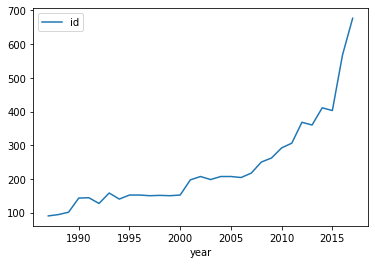

In [24]:
# Visualizando anos de publicação
papers.groupby("year").agg({"id":"count"}).plot()
print(papers.year.unique())

[1985 1990 1995 2000 2005 2010 2015 2020]


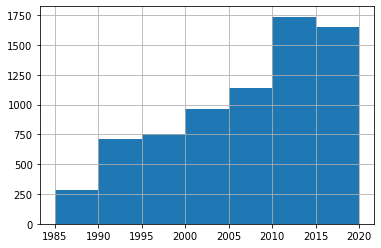

In [25]:
# Criando classes de anos
year_ranges = np.arange(1985,2021,5)
print(year_ranges)
papers.year.hist(bins=year_ranges)

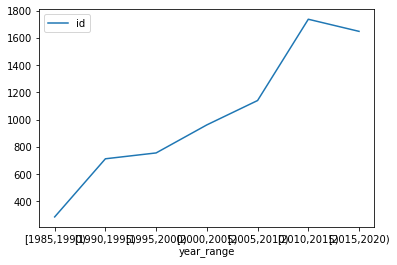

In [26]:
# Criando coluna adicional para agrupar por ano
def get_year_range(year):
    low = year - (year % 5)
    high = low + 5
    return f"[{low},{high})"
papers['year_range'] = papers.year.apply(get_year_range)

papers.groupby('year_range').agg({"id":"count"}).plot()

### 2.2.2. Avaliando modelo ao longo dos anos

Nesta seção, os tópicos e pesos de cada documento (obtidos a partir do modelo de melhor N) serão analisados com relação à classe de anos que pertencem.

In [27]:
# Definindo função para atribuir topicos ao documento
def get_topics(i):
    doc_tokens = corpus_processed[i]
    doc_bow = gensim_dictionary.doc2bow(doc_tokens)
    doc_topics = lda_model.get_document_topics(doc_bow)
    doc_topics = sorted(doc_topics, key=lambda x:x[1], reverse=1)
    return np.array(doc_topics)

# Aplicando em nova coluna do dataset inicial
papers['id'] = papers.index
papers['topics'] = papers.id.apply(get_topics)
papers.sample(3)

,id,year,title,names_count,names_list,event_type,pdf_name,abstract,paper_text,year_range,topics
6308,6308,2016,Learning brain regions via large-scale online ...,4,"[Elvis DOHMATOB, Arthur Mensch, Gael Varoquaux...",Poster,6352-learning-brain-regions-via-large-scale-on...,We propose a multivariate online dictionary-le...,Learning brain regions via large-scale online\...,"[2015,2020)","[[0.0, 0.4386036992073059], [12.0, 0.208866730..."
2775,2775,2005,Cue Integration for Figure/Ground Labeling,3,"[Xiaofeng Ren, Jitendra Malik, Charless C. Fow...",,2814-cue-integration-for-figureground-labeling...,Abstract Missing,Cue Integration for Figure/Ground Labeling\n\n...,"[2005,2010)","[[10.0, 0.7305179238319397], [14.0, 0.09757997..."
6720,6720,2017,Positive-Unlabeled Learning with Non-Negative ...,4,"[Ryuichi Kiryo, Gang Niu, Marthinus C. du Ples...",Oral,6765-positive-unlabeled-learning-with-non-nega...,"From only positive (P) and unlabeled (U) data,...",Positive-Unlabeled Learning with\nNon-Negative...,"[2015,2020)","[[13.0, 0.36381417512893677], [4.0, 0.28238034..."


In [30]:
# Criando dataframe com os tópicos empilhados
papers_years = None
for i in range(0,len(year_ranges)-1):
    low = year_ranges[i]
    high = year_ranges[i+1]
    n_str = f"[{low},{high})"
    p = papers[papers['year_range']==n_str]
    topics_stacked = np.vstack(p.topics.values)
    topics_stackedDF = pd.DataFrame(topics_stacked, columns=['id','weigth'])
    topics_stackedDF_agg = topics_stackedDF.groupby('id').agg({"weigth":"sum"}).sort_values("weigth", ascending=False)

    topics_stackedDF_agg['topic_id'] = topics_stackedDF_agg.index.astype('uint8')
    topics_stackedDF_agg['topic_name'] = topics_stackedDF_agg.topic_id.apply(lambda x: topics_map[x])
    topics_stackedDF_agg['year_range'] = n_str
    
    if i == 0:
        papers_years = topics_stackedDF_agg
    else:
        papers_years = pd.concat([papers_years, topics_stackedDF_agg])
papers_years

,weigth,topic_id,topic_name,year_range
id,,,,
1.0,102.962840,1,01 Redes Neurais 1,"[1985,1990)"
9.0,59.711669,9,09 Redes Neurais 3,"[1985,1990)"
5.0,39.749975,5,05 Treinamento,"[1985,1990)"
6.0,17.515203,6,06 PLN,"[1985,1990)"
12.0,15.733870,12,12 Filtragem,"[1985,1990)"
...,...,...,...,...
6.0,44.510575,6,06 PLN,"[2015,2020)"
11.0,40.846139,11,11 Clusterização,"[2015,2020)"
1.0,35.448661,1,01 Redes Neurais 1,"[2015,2020)"


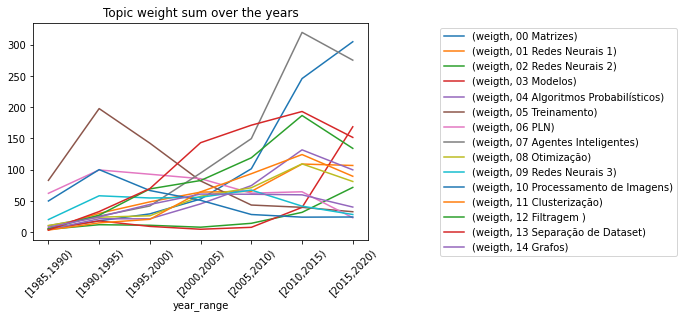

In [271]:
# Plotando soma de peso de cada tópico para casa classe de anos
papers_years \
    .groupby(['year_range','topic_name']).agg({"weigth":"sum"}) \
    .unstack(level=-1) \
    .plot(title="Topic weight sum over the years", rot=45) \
    .legend(bbox_to_anchor=(1.2, 1.0), loc='upper left')

A partir do gráfico acima, é possível ver a evolução de cada tópico ao longo dos anos. Curiosamente, pode-se observar uma diminuição no tópico 06 PLN ao longo dos anos.

### 2.2.3. Gerando modelos com base nas classes de anos

In [161]:
import gensim
from gensim.models import CoherenceModel
from gensim import corpora
import pyLDAvis.gensim
import sys
from collections import defaultdict
import gc
import time
import warnings
warnings.filterwarnings("ignore")

# Dicionário de resultados
results = defaultdict(dict)

In [162]:
n = 15
passes = 20

In [163]:
def topics_over_years(papers, year_ranges, n, passes):
    results = defaultdict(dict)

    # Iterando sobre anos
    for i in range(0,len(year_ranges)-1):
        # Initialization
        start = time.time()
        low = year_ranges[i]
        high = year_ranges[i+1]
        n_str = f"[{low},{high})"
        print(f"range: {n_str}",end=" | ")

        # Data prep
        print("preproc",end=" | ")
        papers_range = papers[(low <= papers['year']) & (papers['year'] < high)]
        corpus_ = papers_range['paper_text'].values
        corpus_processed = list(map(tokenizer_lemma, corpus_))
        gensim_dictionary = corpora.Dictionary(corpus_processed)
        gensim_corpus = list(map(lambda x:gensim_dictionary.doc2bow(x, allow_update=True), corpus_processed))

        # Train
        print("train",end=" | ")
        lda_model = gensim.models.ldamodel.LdaModel(gensim_corpus, num_topics=n, id2word=gensim_dictionary, passes=passes)

        # Eval
        print("eval",end=" | ")
        # Perplexity    
        perplexity = lda_model.log_perplexity(gensim_corpus)
        print("perplexity: {:0.2f}".format(perplexity),end=" | ")

        # Coherence
        coherence_score_lda = CoherenceModel(model=lda_model, texts=corpus_processed, dictionary=gensim_dictionary, coherence='c_v')
        coherence_score = coherence_score_lda.get_coherence()
        print("coherence: {:0.2f}".format(coherence_score),end=" | ")

        # Results
        results[n_str]['start_year'] = low
        results[n_str]['dictionary'] = gensim_dictionary
        results[n_str]['corpus'] = gensim_corpus
        results[n_str]['n'] = n
        results[n_str]['passes'] = passes
        results[n_str]['model'] = lda_model
        results[n_str]['perplexity'] = perplexity
        results[n_str]['coherence'] = coherence_score

        # Runtime
        runtime = (time.time() - start)/60
        results[n_str]['runtime'] = runtime
        print("runtime: {:0.2f} m".format(runtime),end=" | ")

        # Remaining time
        end_time = runtime*(len(year_ranges)-1-(i+1))
        print("ECT: {:0.2f} m \n".format(end_time),end="")
    results_years = pd.DataFrame.from_dict(results, orient='index')
    # Salvando resultados em csv
    results_years.to_csv('results_years.csv', sep=';')
    results_years.to_pickle('results_years.pickle')
    return results_years

In [164]:
# Running
results_years = topics_over_years(papers, year_ranges, n, passes)

range: [1985,1990) | preproc | train | eval | perplexity: -7.76 | coherence: 0.32 | runtime: 1.13 m | ECT: 6.78 m 
range: [1990,1995) | preproc | train | eval | perplexity: -7.75 | coherence: 0.36 | runtime: 2.60 m | ECT: 12.99 m 
range: [1995,2000) | preproc | train | eval | perplexity: -7.72 | coherence: 0.38 | runtime: 2.92 m | ECT: 11.68 m 
range: [2000,2005) | preproc | train | eval | perplexity: -7.68 | coherence: 0.42 | runtime: 4.22 m | ECT: 12.67 m 
range: [2005,2010) | preproc | train | eval | perplexity: -7.67 | coherence: 0.35 | runtime: 5.73 m | ECT: 11.45 m 
range: [2010,2015) | preproc | train | eval | perplexity: -7.66 | coherence: 0.39 | runtime: 9.62 m | ECT: 9.62 m 
range: [2015,2020) | preproc | train | eval | perplexity: -7.73 | coherence: 0.41 | runtime: 9.77 m | ECT: 0.00 m 


### 2.2.4. Visualizando tópicos ao longo dos anos

Nesta seção, os modelos gerados com base nas classes de anos são visualizados com o intuito de comparar as distribuições e distâncias entre os tópicos e o conteúdo dos mesmos ao longo dos anos.

In [110]:
# Visualizando tópicos
import pyLDAvis.gensim

In [272]:
key = '[1985,1990)'
pyLDAvis.display(pyLDAvis.gensim.prepare(
    results_years['model'][key], results_years['corpus'][key], results_years['dictionary'][key], sort_topics=False))

In [274]:
key = '[1990,1995)'
pyLDAvis.display(pyLDAvis.gensim.prepare(
    results_years['model'][key], results_years['corpus'][key], results_years['dictionary'][key], sort_topics=False))

In [275]:
key = '[1995,2000)'
pyLDAvis.display(pyLDAvis.gensim.prepare(
    results_years['model'][key], results_years['corpus'][key], results_years['dictionary'][key], sort_topics=False))

In [276]:
key = '[2000,2005)'
pyLDAvis.display(pyLDAvis.gensim.prepare(
    results_years['model'][key], results_years['corpus'][key], results_years['dictionary'][key], sort_topics=False))

In [277]:
key = '[2005,2010)'
pyLDAvis.display(pyLDAvis.gensim.prepare(
    results_years['model'][key], results_years['corpus'][key], results_years['dictionary'][key], sort_topics=False))

In [278]:
key = '[2010,2015)'
pyLDAvis.display(pyLDAvis.gensim.prepare(
    results_years['model'][key], results_years['corpus'][key], results_years['dictionary'][key], sort_topics=False))

In [279]:
key = '[2015,2020)'
pyLDAvis.display(pyLDAvis.gensim.prepare(
    results_years['model'][key], results_years['corpus'][key], results_years['dictionary'][key], sort_topics=False))

# 3. Similaridade de Textos + Sumarização

## 3.1. Gerando matriz de similaridade entre tópicos

Nesta seção uma matriz de similaridade por cosseno é criada com base nos tópicos de cada documento.

In [33]:
# Função para preencher tópicos que não apareceram nos documentos, e organizar por índice
def fill_blank_topics(x):
    for i in range(15):
        if i not in list(zip(*x))[0]:
            x = np.append(x, [[i,0]], axis=0)
    x = sorted(x, key = lambda x: x[0])
    x = np.array(list(zip(*x))[1])
    return x
papers.topics.apply(lambda x: np.append(x, [[0,0]], axis=0))
papers['topics'] = papers.topics.apply(fill_blank_topics)

In [34]:
stacked = np.stack(papers.topics.values)
stacked.shape

(7238, 15)

In [35]:
# Criando matriz de similaridade por cosseno
from sklearn.metrics.pairwise import cosine_similarity

doc_sim = cosine_similarity(stacked)
doc_sim_df = pd.DataFrame(doc_sim)
doc_sim_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,7198,7199,7200,7201,7202,7203,7204,7205,7206,7207,7208,7209,7210,7211,7212,7213,7214,7215,7216,7217,7218,7219,7220,7221,7222,7223,7224,7225,7226,7227,7228,7229,7230,7231,7232,7233,7234,7235,7236,7237
0,1.000000,0.370176,0.598276,0.387045,0.527740,0.370498,0.355764,0.100147,0.279128,0.140417,0.506020,0.245598,0.266222,0.457283,0.041523,0.738348,0.516231,0.169255,0.340859,0.415701,0.502752,0.193819,0.092987,0.479588,0.427161,0.859907,0.321354,0.469303,0.306332,0.862452,0.172525,0.186454,0.509274,0.064565,0.559023,0.346191,0.294139,0.020851,0.288537,0.401419,...,0.046136,0.168965,0.126517,0.017771,0.125099,0.055145,0.128957,0.076579,0.108120,0.058726,0.110477,0.008813,0.294304,0.618054,0.079531,0.093821,0.106501,0.136701,0.242096,0.142265,0.322081,0.051737,0.163192,0.000000,0.382115,0.110082,0.170013,0.363219,0.128976,0.028624,0.069112,0.035509,0.247582,0.136098,0.042224,0.042196,0.196339,0.297590,0.249098,0.017521
1,0.370176,1.000000,0.814889,0.538201,0.817327,0.868762,0.706002,0.400654,0.838101,0.644988,0.865256,0.330837,0.796721,0.832840,0.410060,0.757795,0.327050,0.624693,0.691901,0.847535,0.883323,0.785219,0.499380,0.237410,0.661627,0.482291,0.902659,0.826522,0.938269,0.432189,0.635373,0.772028,0.478655,0.323890,0.901741,0.892816,0.747844,0.332147,0.887922,0.467520,...,0.000000,0.093333,0.199863,0.020114,0.356805,0.074428,0.098861,0.157711,0.007911,0.024797,0.063964,0.027593,0.046865,0.049481,0.040603,0.070761,0.144705,0.236984,0.020062,0.133677,0.521319,0.098688,0.004842,0.000000,0.134946,0.000000,0.238001,0.007358,0.011578,0.085125,0.074053,0.000000,0.334159,0.000000,0.052406,0.019638,0.266187,0.527838,0.349653,0.000000
2,0.598276,0.814889,1.000000,0.654974,0.688716,0.895668,0.738418,0.160291,0.880557,0.413745,0.906512,0.265554,0.658398,0.915856,0.125391,0.964865,0.362412,0.403325,0.772793,0.882322,0.969209,0.606349,0.218739,0.210240,0.566983,0.819797,0.868044,0.886310,0.900046,0.778825,0.318815,0.539172,0.667893,0.061141,0.975227,0.827843,0.607080,0.047583,0.903810,0.516576,...,0.120152,0.112397,0.188546,0.073352,0.355555,0.111070,0.029872,0.200383,0.078570,0.095285,0.046207,0.047401,0.053129,0.190395,0.047264,0.087190,0.050539,0.050175,0.022683,0.065775,0.273652,0.137853,0.009401,0.109265,0.143945,0.074439,0.087611,0.089609,0.037340,0.202241,0.012849,0.047822,0.097061,0.032638,0.014249,0.098220,0.068414,0.309914,0.078616,0.087371
3,0.387045,0.538201,0.654974,1.000000,0.469100,0.639273,0.490403,0.136028,0.700067,0.308998,0.625409,0.173350,0.458536,0.618028,0.123741,0.638735,0.347301,0.322538,0.893201,0.591095,0.642462,0.435878,0.184869,0.151107,0.568454,0.572203,0.620280,0.651250,0.607455,0.519826,0.237390,0.391320,0.444351,0.081840,0.650101,0.789595,0.439151,0.071027,0.603100,0.358880,...,0.025389,0.128293,0.696946,0.012092,0.236461,0.110881,0.192369,0.105396,0.024091,0.037508,0.002561,0.752732,0.102767,0.130240,0.020559,0.022591,0.419045,0.073485,0.245702,0.091979,0.222906,0.066279,0.000000,0.080647,0.230878,0.142092,0.533103,0.051918,0.067213,0.461143,0.702379,0.011127,0.000000,0.013115,0.736253,0.165797,0.000000,0.191840,0.001317,0.401019
4,0.527740,0.817327,0.688716,0.469100,1.000000,0.771252,0.742159,0.777448,0.599620,0.846147,0.857829,0.632710,0.860719,0.654747,0.712034,0.681678,0.538151,0.855780,0.624923,0.819899,0.771208,0.900742,0.773357,0.744200,0.854006,0.561630,0.824085,0.791689,0.728675,0.525898,0.861856,0.887145,0.474932,0.671137,0.732714,0.624828,0.901916,0.676861,0.688367,0.740576,...,0.136410,0.136406,0.197990,0.023248,0.287656,0.070870,0.120126,0.160643,0.033494,0.078397,0.109315,0.026006,0.150617,0.277664,0.032821,0.365154,0.089990,0.209769,0.098996,0.140044,0.341951,0.069857,0.045819,0.048111,0.237406,0.056171,0.180733,0.108097,0.035348,0.096109,0.053679,0.011206,0.200098,0.045123,0.032826,0.064611,0.161172,0.401994,0.235146,0.032553


## 3.2. Recomendando Artigos com base no título

In [31]:
# Obtendo título aleatório
papers.sample(1).title.values[0]

'A Screening Rule for l1-Regularized Ising Model Estimation'

In [60]:
# Abaixo é criada e testada uma função para recomendar artigos com base na similaridade de tópicos
from gensim.summarization.summarizer import summarize

def recommender_title(title, titles_list=papers.title.values, doc_sims=doc_sim_df, n=5):
    idx = np.where(titles_list == title)[0][0]

    similarities = doc_sims.iloc[idx].values
    
    similar_idxs = np.argsort(-similarities)[0:n+1]
    
    similars = papers.iloc[similar_idxs][['title','year','names_list','topics','paper_text']]
    similars['summary'] = similars.paper_text.apply(summarize)
    similars.drop(['paper_text'],axis=1,inplace=True)
    similars['topics'] = similars.topics.apply(lambda x: list(zip(topics_map,x)))
    
    return similars

recommendation = recommender_title('Distributed Delayed Stochastic Optimization')
recommendation

,title,year,names_list,topics,summary
4208,Distributed Delayed Stochastic Optimization,2011,"[Alekh Agarwal, John C. Duchi]","[(00 Matrizes, 0.0), (01 Redes Neurais 1, 0.06...",We analyze the convergence of gradient-based o...
6898,Limitations on Variance-Reduction and Accelera...,2017,[Yossi Arjevani],"[(00 Matrizes, 0.0), (01 Redes Neurais 1, 0.0)...",Schemes for Finite Sum Optimization\nWe study ...
7151,Asynchronous Coordinate Descent under More Rea...,2017,"[Tao Sun, Robert Hannah, Wotao Yin]","[(00 Matrizes, 0.0), (01 Redes Neurais 1, 0.0)...","However, our understanding of these algorithms..."
5688,Communication Complexity of Distributed Convex...,2015,"[Yossi Arjevani, Ohad Shamir]","[(00 Matrizes, 0.021009420976042747), (01 Rede...",ohad.shamir@weizmann.ac.il\nWe study the funda...
7232,Stochastic Mirror Descent in Variationally Coh...,2017,"[Zhengyuan Zhou, Panayotis Mertikopoulos, Nich...","[(00 Matrizes, 0.02090771123766899), (01 Redes...",Variationally Coherent Optimization Problems\n...
6071,Linear-Memory and Decomposition-Invariant Line...,2016,"[Dan Garber, Dan Garber, Ofer Meshi]","[(00 Matrizes, 0.025901081040501595), (01 Rede...",Linearly Convergent Conditional Gradient Algor...


Neste exemplo, a função recomendadora retornou 2 artigos com o mesmo nome entre os autores.

In [65]:
# Examinando a melhor recomendação
print("Best recommendation from", recommendation.title.values[0],"\n")
print('Title:', recommendation.title.values[1])
print('Topics:', recommendation.topics.values[1])
print('Summary:', recommendation.summary.values[1][:1000],'...')

Best recommendation from Distributed Delayed Stochastic Optimization 

Title: Limitations on Variance-Reduction and Acceleration Schemes for Finite Sums Optimization
Topics: [('00 Matrizes', 0.0), ('01 Redes Neurais 1', 0.0), ('02 Redes Neurais 2', 0.0), ('03 Modelos', 0.0), ('04 Algoritmos Probabilísticos', 0.02219662442803383), ('05 Treinamento', 0.0), ('06 PLN', 0.0), ('07 Agentes Inteligentes', 0.02456747367978096), ('08 Otimização', 0.8336969017982483), ('09 Redes Neurais 3', 0.0), ('10 Processamento de Imagens', 0.0), ('11 Clusterização', 0.0), ('12 Filtragem ', 0.0), ('13 Separação de Dataset', 0.015333238057792187), ('14 Grafos', 0.10090517997741699)]
Summary: Schemes for Finite Sum Optimization
We study the conditions under which one is able to efficiently apply variancereduction and acceleration schemes on finite sum optimization problems.
function is being referred to by the oracle at each iteration.
a broad class of first-order and coordinate-descent finite sum algorithms (

In [63]:
# Testando a função com títulos aleatórios
recommender_title(papers.sample(1).title.values[0])

,title,year,names_list,topics,summary
276,Collective Oscillations in the Visual Cortex,1989,"[Daniel M. Kammen, Christof Koch, Philip J. Ho...","[(00 Matrizes, 0.0), (01 Redes Neurais 1, 0.09...",The firing patterns of populations of cells in...
126,Modeling Small Oscillating Biological Networks...,1988,"[Sylvie Ryckebusch, James M. Bower, Carver Mead]","[(00 Matrizes, 0.0), (01 Redes Neurais 1, 0.10...",We have used analog VLSI technology to model a...
214,Mechanisms for Neuromodulation of Biological N...,1989,[Ronald M. Harris-Warrick],"[(00 Matrizes, 0.0), (01 Redes Neurais 1, 0.10...",The pyloric Central Pattern Generator of the c...
1300,Orientation Contrast Sensitivity from Long-ran...,1996,"[Klaus Pawelzik, Udo Ernst, Fred Wolf, Theo Ge...","[(00 Matrizes, 0.01507244911044836), (01 Redes...",long-range interactions in visual cortex\nPawe...
2292,Neuromorphic Bisable VLSI Synapses with Spike-...,2002,[Giacomo Indiveri],"[(00 Matrizes, 0.0), (01 Redes Neurais 1, 0.07...",We present analog neuromorphic circuits for im...
949,A model of the hippocampus combining self-orga...,1994,"[Michael E. Hasselmo, Eric Schnell, Joshua Ber...","[(00 Matrizes, 0.0), (01 Redes Neurais 1, 0.09...",A model of the hippocampus combining selforgan...
